# Prepare models for implementation

Version 6/27/2017
Steve Klosterman, steve.klosterman@gmail.com

This notebook shows how the models developed here https://github.com/klostest/NYCDEP/blob/master/Sewer_overflow_and_bacteria_project.ipynb , can be put in their "final versions" that are ready to implement on the website.  Note that the final versions need to be trained with the same kind of data that will be available on the website, i.e. the tide, temperature, and rainfall data need to come from the same sources (have the same baselines or reference values, calculated from the same inputs using the same formulas) and be in the same units, or be converted to the equivalent, before being passed to the model.  This issue is currently outstanding.

However, in terms of the syntax and usage of the model for website implementation, it will be identical to what is shown here.

The structure of the notebook is to train the CSO model (held in the Python object 'est_cso'), then illustrate how it can be used on the website with example input data taken as a random point in time from the training data set (2002-2012).  A random case (most likely negative since 99% of times don't have CSO events) is illustrated, as well as a case that is guaranteed to have a positive event.  This sequence is repeated for the fecal coliform model.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import datetime
import timeit
import statsmodels.api as sm
import sklearn
from sklearn.externals import joblib
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

/Users/Steve/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Load the data.
path = './data/'

# #Takes ~ 1 minute to load spreadsheet
# fname = 'ci2002_2011pathogenLOADand2008nutrient_carbonLOAD_20170517D.xlsx'
# rain_cso_df = pd.read_excel(path + fname, sheetname='Outfall_pathogenLoad_part1', header=3, \
#                     index_col=2)

#Save time by saving/loading pickle
# rain_cso_df.to_pickle(path + 'rain_cso_df.pkl')

rain_cso_df = pd.read_pickle(path + 'rain_cso_df.pkl')

In [3]:
#Start off dataframe by subsetting to only one of the repetitions of the year series
cso_qual_df = rain_cso_df.filter(['Year'])
mask = rain_cso_df['Station ID'].isin(['OH-21C'])
cso_qual_df = cso_qual_df[mask]
cso_name = 'CSO OH-21C MG/hr'

cso_qual_df[cso_name] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-21C'])]['(MG/Hour)']
cso_qual_df['Rain, in/hr'] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-21C'])]['(in/hr)']

In [4]:
#Create array of datetime objects to use in dataframe index, and for plotting
#Include rounding of days for whole number hours

helper = np.vectorize(lambda x: datetime.timedelta(hours=x))
start_day = datetime.datetime(2002, 1, 1)
#Change index to hours from days and round to whole hours
cso_qual_df.index = np.round(cso_qual_df.index.values*24.)
time_array = helper(cso_qual_df.index) + start_day
cso_qual_df.index = time_array

In [5]:
#Change to classification problem
cso_qual_df.loc[cso_qual_df[cso_name] > 0, cso_name] = 1

In [6]:
cso_qual_df.head()

,Year,CSO OH-21C MG/hr,"Rain, in/hr"
2002-01-01 00:00:00,2002,0.0,0.0
2002-01-01 01:00:00,2002,0.0,0.0
2002-01-01 02:00:00,2002,0.0,0.0
2002-01-01 03:00:00,2002,0.0,0.0
2002-01-01 04:00:00,2002,0.0,0.0


In [7]:
#Get unique years
un_years = np.unique(cso_qual_df['Year'])
print(un_years, 'length', len(un_years))

(array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]), 'length', 10)


In [8]:
# load tides/temps data and add
tides_temps_df = pd.read_pickle('./addl_climate_data/tides_temps_df.pkl')
# merge; should have same index
cso_qual_df = cso_qual_df.merge(tides_temps_df, how='inner', left_index=True, right_index=True)
cso_qual_df.head()

,Year,CSO OH-21C MG/hr,"Rain, in/hr",Tide prediction (ft),Air temp (F)
2002-01-01 00:00:00,2002,0.0,0.0,1.497,25.00
2002-01-01 01:00:00,2002,0.0,0.0,0.395,24.00
2002-01-01 02:00:00,2002,0.0,0.0,-0.360,24.85
2002-01-01 03:00:00,2002,0.0,0.0,-0.539,23.85
2002-01-01 04:00:00,2002,0.0,0.0,0.111,22.85


## Model training

In [9]:
#Inputs
#model: sklearn model for traning and testing
#lag_order: positive integer, number of time lags (hours) to include in addition to current point in model
#column_to_model: string, column name from Pandas dataframe that will be used as response variable
#predictors: list of strings, column names from Pandas dataframe that will be used as predictors
#
#Outputs
#est: list of trained sklearn model objects
#X: training data predictors
#y: training data responses

def train_model(model, lag_order, column_to_model, predictors):

    #Filter to only include columns used here for model training
    filter_columns = predictors[:] #create copy of list of predictors
    filter_columns.append(column_to_model) #append the response variable
    train_data = cso_qual_df.filter(filter_columns, axis=1)

    #Create time lagged columns for each predictor
    for this_lag in range(1,lag_order+1):
        for this_pred in predictors:
            train_data.insert\
                (0, this_pred + ' lag '+ str(this_lag),\
                train_data[this_pred].shift(this_lag))

    #Drop rows with NaNs that were introduced by shifting to get lags
    train_data.dropna(axis=0, inplace=True)

    #Make arrays of predictors and response
    X = train_data.drop([column_to_model], axis=1).values
    y = train_data.filter([column_to_model], axis=1).values

    #Fit model in sklearn
    est = model.fit(X, y)
        
    #Return trained model
    return est, X, y, train_data

In [10]:
#Create a logistic model object for training/testing
from sklearn import linear_model
logistic_reg_model = linear_model.LogisticRegression(fit_intercept = True, class_weight='balanced', C=1000000)

In [11]:
#Train the model for CSOs
lag_order = 12
[est_cso, X_cso, y_cso, train_data_cso] = train_model(model=logistic_reg_model,\
    lag_order=lag_order,\
    column_to_model=cso_name,\
    predictors=['Rain, in/hr', 'Tide prediction (ft)'])

/Users/Steve/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
#See what the training data looked like
train_data_cso.head()

,Tide prediction (ft) lag 12,"Rain, in/hr lag 12",Tide prediction (ft) lag 11,"Rain, in/hr lag 11",Tide prediction (ft) lag 10,"Rain, in/hr lag 10",Tide prediction (ft) lag 9,"Rain, in/hr lag 9",Tide prediction (ft) lag 8,"Rain, in/hr lag 8",...,"Rain, in/hr lag 4",Tide prediction (ft) lag 3,"Rain, in/hr lag 3",Tide prediction (ft) lag 2,"Rain, in/hr lag 2",Tide prediction (ft) lag 1,"Rain, in/hr lag 1","Rain, in/hr",Tide prediction (ft),CSO OH-21C MG/hr
2002-01-01 12:00:00,1.497,0.0,0.395,0.0,-0.360,0.0,-0.539,0.0,0.111,0.0,...,0.0,5.677,0.0,5.201,0.0,4.112,0.0,0.0,2.704,0.0
2002-01-01 13:00:00,0.395,0.0,-0.360,0.0,-0.539,0.0,0.111,0.0,1.532,0.0,...,0.0,5.201,0.0,4.112,0.0,2.704,0.0,0.0,1.321,0.0
2002-01-01 14:00:00,-0.360,0.0,-0.539,0.0,0.111,0.0,1.532,0.0,3.227,0.0,...,0.0,4.112,0.0,2.704,0.0,1.321,0.0,0.0,0.156,0.0
2002-01-01 15:00:00,-0.539,0.0,0.111,0.0,1.532,0.0,3.227,0.0,4.632,0.0,...,0.0,2.704,0.0,1.321,0.0,0.156,0.0,0.0,-0.613,0.0
2002-01-01 16:00:00,0.111,0.0,1.532,0.0,3.227,0.0,4.632,0.0,5.471,0.0,...,0.0,1.321,0.0,0.156,0.0,-0.613,0.0,0.0,-0.695,0.0


In [13]:
#Get training metrics
y_pred_cso = est_cso.predict(X_cso)
train_proba_cso = est_cso.predict_proba(X_cso)
train_roc_cso = sklearn.metrics.roc_curve(y_cso, train_proba_cso[:,1])
train_acc_cso = est_cso.score(X_cso, y_cso)
train_metrics_cso = sklearn.metrics.precision_recall_fscore_support(y_cso, y_pred_cso)

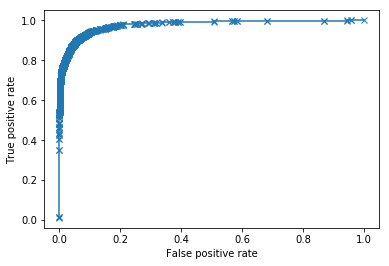

In [14]:
#Plot ROC curve
plt.plot(train_roc_cso[0], train_roc_cso[1], '-x')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [15]:
#What is the treshold that results in 90% true positive rate?
want_true_pos = 0.90
#The difference between desired and all true positive rates in the ROC curve
roc_diff = train_roc_cso[1] - want_true_pos
#Index of the closest to desired
roc_index = np.argmin(np.abs(roc_diff))
actual_true_pos = train_roc_cso[1][roc_index]
false_pos_rate_for_this_true_pos = train_roc_cso[0][roc_index]
thresh_for_this_true_cso = train_roc_cso[2][roc_index]
print('For true positive rate {:0.2f}, the false positive rate is {:0.2f} and the threshold is {:0.2f}'.format\
     (actual_true_pos, false_pos_rate_for_this_true_pos, thresh_for_this_true_cso))

For true positive rate 0.90, the false positive rate is 0.06 and the threshold is 0.53


Now I've trained the model for CSOs on all years of data.  I have the inputs that, in addition to future data, are necessary for the website implementation:  the trained model 'est_cso' and the threshold for declaring an event, 'thresh_for_this_true_cso'.

## Website implementation

On the website, the trained model can be used directly for prediction.  The input will be an array called 'rain_tide_data', with dimensions 1x26, and elements arranged as: water level 12 hrs ago, rainfall 12 hrs ago, water level 11 hrs ago, rainfall 11 hrs ago, ... water level now, rainfall now.  The format is illustrated above as the columns of 'train_data_cso.head()', minus the last column which is the response (i.e. output) variable.

This array will be input to the trained model 'est_cso', using the 'predict_proba' method.  This returns the probability of a CSO occurring at the current time, 'event_proba_cso'.  This probability triggers the 'event_flag_cso' to be True if it's above the threshold ('thresh_for_this_true_cso', or 0.53), and False otherwise.  The 'event_flag_cso' can be used to color the map for the public warning system of when a CSO is occurring.

Here I select a random row from the training data to illustrate the procedure.

In [16]:
#Select random row from predictors of training data (X)
random_row_index = np.random.randint(low=0, high=np.shape(X_cso)[0])
rain_tide_data = X_cso[random_row_index,:]

#Show the shape of the data
np.shape(rain_tide_data)

(26,)

In [17]:
#Use the trained model 'est' to predict probability of CSO outflow for this time
event_proba_cso = est_cso.predict_proba(rain_tide_data.reshape(1,-1))
#Set event variable to True if probability is above the threshold, False otherwise
event_flag_cso = (event_proba_cso[0][1]>thresh_for_this_true_cso)
event_flag_cso

False

In [18]:
#Confirm with the event from response of training data (y) (0. = False, 1 = True )
y_cso[random_row_index]

array([ 0.])

For peace of mind, I find a time of CSO overflow and test the implementation there.

In [19]:
#Try it with a positive event (only ~1% of data)
pos_row_index = np.random.choice(np.nonzero(y_cso)[0])
#Repeat the rest
rain_tide_data = X_cso[pos_row_index,:]
event_proba_cso = est_cso.predict_proba(rain_tide_data.reshape(1,-1))
event_flag_cso = (event_proba_cso[0][1]>thresh_for_this_true_cso)
event_flag_cso

True

In [20]:
#Confirm with the event from the training data (0. = False, 1 = True )
y_cso[pos_row_index]

array([ 1.])

Looks like it works!  Note there is a chance that the model would make an incorrect prediction, however.  This is now ready to be tested on the website.

## Train model for bacteria event

In [21]:
#Load pathogen data and add it to the data frame

# fname = 'ci_baseline_2002_2011pathogen_and_2008dissolved_oxygen_20170509B.xlsx'
# patho_df = pd.read_excel(path + fname, sheetname='ten_year_pathogen', header=3, \
#                     index_col=2)

#Pickle for faster loading
# patho_df.to_pickle(path + 'patho_df.pkl')  # where to save it, usually as a .pkl
patho_df = pd.read_pickle(path + 'patho_df.pkl')

In [22]:
patho_df.head()

,Station ID,Year,Fecal Coliform,Enterococcus,Station ID.1,Fecal Coliform.1,Enterococcus.1,Station ID.2,Fecal Coliform.2,Enterococcus.2,(in/hr)
(day),,,,,,,,,,,
0.00000,CIC2,2002,44,30,CIC3,37,19,GB1,28,7,0.0
0.04167,CIC2,2002,44,30,CIC3,37,19,GB1,29,7,0.0
0.08333,CIC2,2002,41,27,CIC3,36,19,GB1,31,8,0.0
0.12500,CIC2,2002,39,25,CIC3,35,17,GB1,36,10,0.0
0.16667,CIC2,2002,38,25,CIC3,34,17,GB1,38,11,0.0


In [23]:
#Add binarized version to existing dataframe
regulation_limit = 1000. #this could be updated if regulations change

cso_qual_df['Fecal Coliform 1'] = patho_df['Fecal Coliform'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] < regulation_limit, 'Fecal Coliform 1'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] >= regulation_limit, 'Fecal Coliform 1'] = 1

cso_qual_df['Fecal Coliform 2'] = patho_df['Fecal Coliform.1'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] < regulation_limit, 'Fecal Coliform 2'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] >= regulation_limit, 'Fecal Coliform 2'] = 1

cso_qual_df['Fecal Coliform 3'] = patho_df['Fecal Coliform.2'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] < regulation_limit, 'Fecal Coliform 3'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] >= regulation_limit, 'Fecal Coliform 3'] = 1

In [24]:
cso_qual_df.head()

,Year,CSO OH-21C MG/hr,"Rain, in/hr",Tide prediction (ft),Air temp (F),Fecal Coliform 1,Fecal Coliform 2,Fecal Coliform 3
2002-01-01 00:00:00,2002,0.0,0.0,1.497,25.00,0,0,0
2002-01-01 01:00:00,2002,0.0,0.0,0.395,24.00,0,0,0
2002-01-01 02:00:00,2002,0.0,0.0,-0.360,24.85,0,0,0
2002-01-01 03:00:00,2002,0.0,0.0,-0.539,23.85,0,0,0
2002-01-01 04:00:00,2002,0.0,0.0,0.111,22.85,0,0,0


The rest of the notebook essentially repeats the model training and checking procedure from above, but for the fecal coliform model.

I train the model using the first of the three fecal coliform series.

In [25]:
#Train the model for bacteria
lag_order = 60
#Also note model training time, this one takes a little over a minute
start_time = timeit.default_timer()
[est_fc, X_fc, y_fc, train_data_fc] = train_model(model=logistic_reg_model,\
    lag_order=lag_order,\
    column_to_model='Fecal Coliform 1',\
    predictors=['Rain, in/hr', 'Tide prediction (ft)', 'Air temp (F)'])
elapsed = timeit.default_timer() - start_time
elapsed

71.6301338672638

In [26]:
#See what the training data looked like
train_data_fc.head()

,Air temp (F) lag 60,Tide prediction (ft) lag 60,"Rain, in/hr lag 60",Air temp (F) lag 59,Tide prediction (ft) lag 59,"Rain, in/hr lag 59",Air temp (F) lag 58,Tide prediction (ft) lag 58,"Rain, in/hr lag 58",Air temp (F) lag 57,...,Air temp (F) lag 2,Tide prediction (ft) lag 2,"Rain, in/hr lag 2",Air temp (F) lag 1,Tide prediction (ft) lag 1,"Rain, in/hr lag 1","Rain, in/hr",Tide prediction (ft),Air temp (F),Fecal Coliform 1
2002-01-03 12:00:00,25.00,1.497,0.0,24.00,0.395,0.0,24.85,-0.360,0.0,23.85,...,30.130435,5.248,0.0,31.0,5.326,0.0,0.0,4.730,32.30,0
2002-01-03 13:00:00,24.00,0.395,0.0,24.85,-0.360,0.0,23.85,-0.539,0.0,22.85,...,31.000000,5.326,0.0,32.3,4.730,0.0,0.0,3.548,33.00,0
2002-01-03 14:00:00,24.85,-0.360,0.0,23.85,-0.539,0.0,22.85,0.111,0.0,22.15,...,32.300000,4.730,0.0,33.0,3.548,0.0,0.0,2.138,36.00,0
2002-01-03 15:00:00,23.85,-0.539,0.0,22.85,0.111,0.0,22.15,1.532,0.0,23.00,...,33.000000,3.548,0.0,36.0,2.138,0.0,0.0,0.859,35.70,0
2002-01-03 16:00:00,22.85,0.111,0.0,22.15,1.532,0.0,23.00,3.227,0.0,23.00,...,36.000000,2.138,0.0,35.7,0.859,0.0,0.0,-0.105,33.85,0


In [27]:
#Get training metrics
y_pred_fc = est_fc.predict(X_fc)
train_proba_fc = est_fc.predict_proba(X_fc)
train_roc_fc = sklearn.metrics.roc_curve(y_fc, train_proba_fc[:,1])
train_acc_fc = est_fc.score(X_fc, y_fc)
train_metrics_fc = sklearn.metrics.precision_recall_fscore_support(y_fc, y_pred_fc)

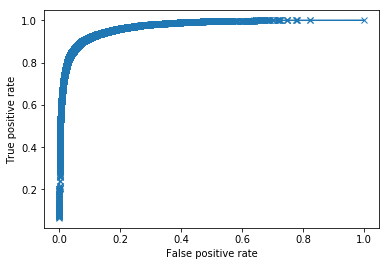

In [28]:
#Plot ROC curve
plt.plot(train_roc_fc[0], train_roc_fc[1], '-x')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [29]:
#What is the treshold that results in 90% true positive rate?
want_true_pos = 0.90
#The difference between desired and all true positive rates in the ROC curve
roc_diff = train_roc_fc[1] - want_true_pos
#Index of the closest to desired
roc_index = np.argmin(np.abs(roc_diff))
actual_true_pos = train_roc_fc[1][roc_index]
false_pos_rate_for_this_true_pos = train_roc_fc[0][roc_index]
thresh_for_this_true_fc = train_roc_fc[2][roc_index]
print('For true positive rate {:0.2f}, the false positive rate is {:0.2f} and the threshold is {:0.2f}'.format\
     (actual_true_pos, false_pos_rate_for_this_true_pos, thresh_for_this_true_fc))

For true positive rate 0.90, the false positive rate is 0.08 and the threshold is 0.46


## Website implementation

On the website, the trained model can be used directly for prediction.  The input will be an array called 'rain_tide_temp_data', with dimensions 1x183, and elements arranged as: air temp 60 hrs ago, water level 60 hrs ago, rainfall 60 hrs ago, air temp 59 hrs ago, water level 59 hrs ago, rainfall 59 hrs ago, ... air temp now, water level now, rainfall now.  The format is illustrated above as the columns of 'train_data.head()', minus the last column which is the response (i.e. output) variable.

This array will be input to the trained model 'est_fc', with the 'predict_proba' method.  This returns the probability of FC > 1000 at the current time, 'event_proba_fc'.  This probability triggers the 'event_flag_fc' to be True if it's above the threshold ('thresh_for_this_true_fc', or 0.46), and False otherwise.  The 'event_flag_fc' can be used to color the map for the public warning system of when fecal coliform is above 1000 colonies per 100 mL.

Here I select a random row from the training data to illustrate the procedure.

In [30]:
#Select random row from predictors of training data (X)
random_row_index = np.random.randint(low=0, high=np.shape(X_fc)[0])
rain_tide_temp_data = X_fc[random_row_index,:]

#Show the shape of the data
np.shape(rain_tide_temp_data)

(183,)

In [31]:
#Use the trained model 'est' to predict probability of CSO outflow for this time
event_proba_fc = est_fc.predict_proba(rain_tide_temp_data.reshape(1,-1))
#Set event variable to True if probability is above the threshold, False otherwise
event_flag_fc = (event_proba_fc[0][1]>thresh_for_this_true_fc)
event_flag_fc

True

In [32]:
#Confirm with the event from response of training data (y) (0. = False, 1 = True )
y_fc[random_row_index]

array([1])

For peace of mind, I find a time of FC > 1000 and test the implementation there.

In [33]:
#Try it with a positive event, about 29% of FC data so not as rare.
pos_row_index = np.random.choice(np.nonzero(y_fc)[0])
#Repeat the rest
rain_tide_temp_data = X_fc[pos_row_index,:]
event_proba_fc = est_fc.predict_proba(rain_tide_temp_data.reshape(1,-1))
event_flag_fc = (event_proba_fc[0][1]>thresh_for_this_true_fc)
event_flag_fc

True

In [34]:
#Confirm with the event from the training data (0. = False, 1 = True )
y_fc[pos_row_index]

array([1])

Looks like it works!  Note there is a chance that the model would make an incorrect prediction, however.  This is now ready to be tested on the website.
